# remove this notebook. It was only for getting confusion matrix

# Parameters to experiment

In [17]:
# training on guanaco
# ATENTION: if it is going to run on guanaco, so comment the %matplotlib magic in next block
trainingOnGuanaco = False

# train without notebook
trainWithJustPython = False

# number_experiment (this is just a name)
# priors:
# 1
number_experiment = 5
number_experiment = str(number_experiment)

# add general comment about experiment 
comment = "training encoder as classifier"

In [3]:
# classes to analyze
# 42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#        95,   6,  53, 994,  64
only_these_labels = [16, 92, 53]
# 53 has 24 light curves

# only_these_labels = [16, 92]
# only_these_labels = [16, 92]
# only_these_labels = [42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#         95,   6,  53, 994,  64]

# VAE parameters
latentDim = 100
hiddenDim = 100
inputDim = 72

# training
epochs = 2000

# band
# passband = 5
passband = 5

batch_training_size = 128

In [4]:
# training params
learning_rate = 1e-3

# Import libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils import data

# from tqdm import tqdm_notebook

# %matplotlib notebook

# import functions to load dataset
import sys
sys.path.append("./codesToDatasets")
from plasticc_dataset_torch import get_plasticc_datasets
# from plasticc_plotting import plot_light_curve

import math

from torch import nn

# Load data

In [6]:
# define path to dataset
pathToFile = "/home/shared/astro/PLAsTiCC/" if trainingOnGuanaco else "/home/leo/Downloads/plasticc_torch-master/"

## Loading dataset with pytorch tool

In [7]:
# torch_dataset_lazy = get_plasticc_datasets(pathToFile)

# Light curves are tensors are now [bands, [mjd, flux, err, mask],
# lc_data, lc_label, lc_plasticc_id                              
torch_dataset_lazy = get_plasticc_datasets(pathToFile, only_these_labels=only_these_labels)

You have selected lazy loading. Light curves will be loaded ondemand from the harddrive
Found 3 csv files at given path
Loading /home/leo/Downloads/plasticc_torch-master/plasticc_train_lightcurves.csv
Loading /home/leo/Downloads/plasticc_torch-master/plasticc_test_set_batch1.csv
Loading /home/leo/Downloads/plasticc_torch-master/plasticc_test_set_batch2.csv


# Spliting data (train/test)

In [8]:
# Spliting the data

# print(torch_dataset_lazy.__len__())

# selecting train splitting
train_size = int(0.8 * torch_dataset_lazy.__len__())
#print(train_size)

# getting test splitting
validation_size = math.floor((torch_dataset_lazy.__len__() - train_size)/2)
#print(validation_size)

# getting test splitting
test_size = torch_dataset_lazy.__len__() - train_size - validation_size
#print(test_size)

# spliting the torch dataset
trainDataset, validationDataset,  testDataset = torch.utils.data.random_split(torch_dataset_lazy, [train_size, validation_size, test_size])

print("train size:", train_size)
print("validation size: ", validation_size)
print("test size:", test_size)
print("sum: ", train_size+ validation_size + test_size)

train size: 25030
validation size:  3129
test size: 3129
sum:  31288


## Create a dataloader

In [9]:
# # Create data loader (minibatches)

# # train loader
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size= batch_training_size, shuffle=True, num_workers = 4)

# validation loader
validationLoader = torch.utils.data.DataLoader(validationDataset, batch_size= batch_training_size, shuffle=True, num_workers = 4)

# # test loader
testLoader = torch.utils.data.DataLoader(testDataset)
# trainLoader = torch.utils.data.DataLoader(torch_dataset_lazy, batch_size=256, shuffle=True, num_workers=0)

## Define autoencoder structure

In [10]:
# implementacion adaptada a 1D de https://github.com/naoto0804/pytorch-inpainting-with-partial-conv

class PartialConv(nn.Module):
    def __init__(self, in_channels_C,in_channels_M, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super().__init__()
        self.input_conv = nn.Conv1d(in_channels_C, out_channels, kernel_size,
                                    stride, padding, dilation, groups, bias)
        self.mask_conv = nn.Conv1d(in_channels_M, out_channels, kernel_size,
                                   stride, padding, dilation, groups, False)
        # self.input_conv.apply(weights_init('kaiming'))

        torch.nn.init.constant_(self.mask_conv.weight, 1.0)

        # mask is not updated
        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self,input, mask):
        # http://masc.cs.gmu.edu/wiki/partialconv
        # C(X) = W^T * X + b, C(0) = b, D(M) = 1 * M + 0 = sum(M)
        # W^T* (M .* X) / sum(M) + b = [C(M .* X) – C(0)] / D(M) + C(0)
        #print(input.shape, mask.shape)
        output = self.input_conv(input * mask)
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        no_update_holes = output_mask == 0
        mask_sum = output_mask.masked_fill_(no_update_holes, 1.0)

        output_pre = (output - output_bias) / mask_sum + output_bias
        output = output_pre.masked_fill_(no_update_holes, 0.0)

        new_mask = torch.ones_like(output)
        new_mask = new_mask.masked_fill_(no_update_holes, 0.0)

        return output, new_mask

In [11]:
# building classifier

# encoder
class Encoder(torch.nn.Module):
    

    # init method
    def __init__(self, latent_dim, hidden_dim, input_dim, num_classes):
    
    
        super(Encoder, self).__init__()
        
        # 1 Convolution layer
        # Conv1d(input channel, output channel, kernel size)
#         self.conv1 = torch.nn.Conv1d(1,64,3)
#         self.conv1 = torch.nn.Conv1d(1,64,3, stride = 2)
        
        # partial convolution
        self.pconv1 = PartialConv(in_channels_C = 1,in_channels_M = 1, out_channels = 64, kernel_size = 3, stride=2, padding=0, dilation=1, bias=True)
        
        # 2 Convolution layer
        # Conv1d(input channel, output channel, kernel size)
#         self.conv2 = torch.nn.Conv1d(64, 32, 3)
#         self.conv2 = torch.nn.Conv1d(64, 32, 3, stride = 2)
        
        # partial convolution
        self.pconv2 = PartialConv(in_channels_C = 64,in_channels_M = 64, out_channels = 32, kernel_size = 3, stride=2, padding=0, dilation=1, bias=True)
        
        
        # linear layer
#         self.hidden1 = torch.nn.Linear(2144*2, hidden_dim)
#         self.hidden1 = torch.nn.Linear(1088, hidden_dim)
        self.hidden1 = torch.nn.Linear(1632, hidden_dim)
        
#         self.hidden2 = torch.nn.Linear(hidden_dim, hidden_dim)
        
        # output layer
        self.outputLayer = torch.nn.Linear(hidden_dim, num_classes)
        
        # activation function
        self.activationConv = torch.nn.ReLU() #max(0, x)
#         self.activationConv = torch.nn.Tanh()
    
        # this works well.(comparing with relu)
        self.activationLinear = torch.nn.Tanh()

        # this is getting nan values
#         self.activationLinear = torch.nn.ReLU()

    # forward method
    def forward(self, x):
        
        # input shape: [batch_size, channels, sequence_length]
        # print("input shape: {0}".format(x.shape))
#         print("input to encoder: ")
#         print(x.shape)
        
        # convolution 1
        # x -> conv -> act -> ouput
        # shape should be: [batch_size, number of ouput channels (64), length of output from convolution]
        
        #conv to time
        # normal convolution
#         outputTimeConv = self.activationConv(self.conv1Time(x[:, 0, :].unsqueeze(1)))
#         outputTimeConv = self.activationConv(self.conv1(x[:, 0, :].unsqueeze(1)))
        # partial conv
        # output, newMask = pconv1(data, mask)
        outputTimeConv, maskTime = self.pconv1(x[:, 0, :].unsqueeze(1), x[:, 3, :].unsqueeze(1))
        # activation function
        outputTimeConv = self.activationConv(outputTimeConv)
        
        
        # conv to magnitude
#         outputMagConv = self.activationConv(self.conv1Mag(x[:, 1, :].unsqueeze(1)))
#         outputMagConv = self.activationConv(self.conv1(x[:, 1, :].unsqueeze(1)))
        
        # partial conv
        # output, newMask = pconv1(data, mask)
        outputMagConv, maskMag = self.pconv1(x[:, 1, :].unsqueeze(1), x[:, 3, :].unsqueeze(1))
        # activation function
        outputMagConv = self.activationConv(outputMagConv)
        
        
        # conv to mag error
#         outputMagErrorConv = self.activationConv(self.conv1(x[:, 2, :].unsqueeze(1)))
        
        # partial conv
        # output, newMask = pconv1(data, mask)
        outputMagErrorConv, maskError = self.pconv1(x[:, 2, :].unsqueeze(1), x[:, 3, :].unsqueeze(1))
        # activation function
        outputMagErrorConv = self.activationConv(outputMagErrorConv)
        
#         print("output conv1 shape: {0}".format(outputMagConv.shape))
#         print("output conv1 shape: {0}".format(outputTimeConv.shape))
        
        # convolution 2
#         # shape should be: [batch_size, number of ouput channels (32), length of output from convolution]
        
        
        # conv to time
#         outputTimeConv = self.activationConv(self.conv2(outputTimeConv))
        
        # partial conv
        outputTimeConv, maskTime = self.pconv2(outputTimeConv, maskTime)
        outputTimeConv = self.activationConv(outputTimeConv)
        
        
        # conv to flux
#         outputMagConv = self.activationConv(self.conv2(outputMagConv))
        # part conv
        outputMagConv, maskMag = self.pconv2(outputMagConv, maskMag)
        outputMagConv = self.activationConv(outputMagConv)
        
        # conv to mag error
#         outputMagErrorConv = self.activationConv(self.conv2(outputMagErrorConv))
        # partial conv
        outputMagErrorConv, maskError = self.pconv2(outputMagErrorConv, maskError)
        outputMagErrorConv = self.activationConv(outputMagErrorConv)
        
#         print("output conv2 shape: {0}".format(outputTimeConv.shape))
#         print("output conv2 shape: {0}".format(outputMagConv.shape))
        
        # flatten ouput
        # shape should be: [batch_size, -1]
        outputMagConv = outputMagConv.view(outputMagConv.shape[0], -1)
        
        outputTimeConv = outputTimeConv.view(outputTimeConv.shape[0], -1)
        
        outputMagErrorConv = outputMagErrorConv.view(outputMagErrorConv.shape[0], -1)
        
#         print("output reshape: ", outputMagConv.shape)
#         print("output reshape: ", outputTimeConv.shape)
                
        # concatenate 3 towers
#         output = torch.cat((outputMagConv, outputTimeConv), 1)
        output = torch.cat((outputTimeConv, outputMagConv, outputMagErrorConv), 1)
#         print("concatenate output shape: ", output.shape)
        
        # x -> hidden1 -> activation
#         print("before linear layer: {0}".format(output.shape))
        output = self.activationLinear(self.hidden1(output))
        # Should be an activiation function here?
#         output = (self.hidden1(output))
        
        output = self.outputLayer(output)
        
        # this should return the classification
        return output

## Defining parameters to Autoencoder

In [12]:
# check number of parameters
# latentDim = 5
# hiddenDim = 10
# inputDim = 72

latentDim = latentDim
hiddenDim = hiddenDim
inputDim = inputDim

passband = passband

num_classes = len(only_these_labels)


# defining model
model = Encoder(latent_dim = latentDim, hidden_dim = hiddenDim, input_dim = inputDim, num_classes = num_classes)


model.cuda()

Encoder(
  (pconv1): PartialConv(
    (input_conv): Conv1d(1, 64, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(1, 64, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv2): PartialConv(
    (input_conv): Conv1d(64, 32, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(64, 32, kernel_size=(3,), stride=(2,), bias=False)
  )
  (hidden1): Linear(in_features=1632, out_features=100, bias=True)
  (outputLayer): Linear(in_features=100, out_features=3, bias=True)
  (activationConv): ReLU()
  (activationLinear): Tanh()
)

In [13]:
print(model)

Encoder(
  (pconv1): PartialConv(
    (input_conv): Conv1d(1, 64, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(1, 64, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv2): PartialConv(
    (input_conv): Conv1d(64, 32, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(64, 32, kernel_size=(3,), stride=(2,), bias=False)
  )
  (hidden1): Linear(in_features=1632, out_features=100, bias=True)
  (outputLayer): Linear(in_features=100, out_features=3, bias=True)
  (activationConv): ReLU()
  (activationLinear): Tanh()
)


In [14]:
# it builds a mask for the deltas. It compares the next with the previous one element.
# original mask: [1,1, 0, 0]
# delta mask: [1, 0, 0]
# The same results is got with original_mask[:, 1:]
def generate_delta_mask(mask):
    
    # generate delta mask
#     mask_delta = mask[:, 1:].type(torch.BoolTensor) & mask[:, :-1].type(torch.BoolTensor)
    mask_delta = mask[:, 1:]
    
    return mask_delta

In [15]:
# function to generate delta time and flux
# data = [batchSize, channels, [time, flux, err, mask], light curve]
def generateDeltas(data, passBand):
    
    # work with delta time and magnitude
    
#     print("generate deltas input shape: {0}".format(data.shape) )
    # delta time
    tmpDeltaTime = data[:, passBand, 0, 1:] - data[:, passBand, 0, :-1]

#     print("generate deltas time shape: {0}".format(tmpDeltaTime.shape) )

#     # delta magnitude
    tmpDeltaMagnitude = data[:, passBand, 1, 1:] - data[:, passBand, 1, :-1]
#     print("generate deltas flux shape: {0}".format(tmpDeltaMagnitude.shape))
    
    # delta errors
    tmpDeltaMagError = data[:, passBand, 2, 1:] - data[:, passBand, 2, :-1]
    
    # delta mask
    tmpMask = generate_delta_mask(data[:, passBand, 3,:])
    
    # concatenate tensors
    dataToUse = torch.cat((tmpDeltaTime.unsqueeze(1), tmpDeltaMagnitude.unsqueeze(1), tmpDeltaMagError.unsqueeze(1), tmpMask.unsqueeze(1)), 1)
#     print("data to use shape: {0}".format(dataToUse.shape))
    
    # normalize data
    # this was commented because it considerate that delta is already a normalization
#     dataToUse = normalizeLightCurve(dataToUse)
    
    # returning data
    return dataToUse

In [16]:
# mapping the labels to classes 0 to C-1

def mapLabels(labels):

    for i in range(len(only_these_labels)):
        
        labels[labels == only_these_labels[i]] = i 
        
    return labels

In [18]:
pathToSaveModel = "/home/lbravo/thesis/thesis/work/thesis/experiments/" + number_experiment + "/model" if trainingOnGuanaco else "/home/leo/Desktop/thesis/work/thesis/experiments/" + number_experiment + "/model"

# model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(pathToSaveModel))

<All keys matched successfully>

In [19]:
# get y true and labels

predictions = np.zeros(shape = (0,))
labels_ = np.zeros(shape = (0,))

# minibatches
for data_ in validationLoader:
        
    data = data_[0].cuda()
    labels = data_[1].cuda()

    data = generateDeltas(data, passband).type(torch.FloatTensor).cuda()

    outputs = model.forward(data)
    
    prediction = torch.argmax(outputs, 1).cpu().numpy()

    label = mapLabels(labels).cpu().numpy()
    
    predictions = np.append(predictions, prediction)
    labels_ = np.append(labels_, label)

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels_, predictions)

print(cm)
# print("saving confusion matrix scores")
# np.savetxt("experiments/" + number_experiment + "/confusionMatrix.csv", cm, delimiter=",")


# np.savetxt("experiments/" + number_experiment + "/clasificationReport.txt", classification_report(labels_, predictions))

print(classification_report(labels_, predictions))

# print("saving clasification report")
# text_file = open("experiments/" + number_experiment + "/clasificationReport.txt", "w")
# text = classification_report(labels_, predictions)
# text_file.write(text)
# text_file.close()
# print("experiment parameters file created")

[[1071   34    0]
 [  72 1929    0]
 [   0    0   23]]
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      1105
         1.0       0.98      0.96      0.97      2001
         2.0       1.00      1.00      1.00        23

    accuracy                           0.97      3129
   macro avg       0.97      0.98      0.98      3129
weighted avg       0.97      0.97      0.97      3129



In [6]:
import pandas as pd
cm = pd.read_csv('./experiments/5/confusionMatrix.csv', header = None) 

cm

,0,1,2
0,9329.0,317.0,0.0
1,686.0,19165.0,4.0
2,0.0,11.0,125.0


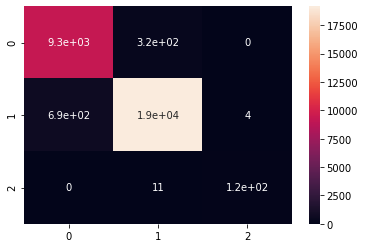

In [10]:
import seaborn as sn

sn.heatmap(cm, annot=True)

In [11]:
cat ./experiments/5/clasificationReport.txt

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      9646
         1.0       0.98      0.97      0.97     19855
         2.0       0.97      0.92      0.94       136

    accuracy                           0.97     29637
   macro avg       0.96      0.95      0.96     29637
weighted avg       0.97      0.97      0.97     29637
